In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("Dataset.csv")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CustomerID       800 non-null    int64 
 1   Gender           800 non-null    object
 2   Age              800 non-null    int64 
 3   Annual Income    800 non-null    int64 
 4   Spending Score   800 non-null    int64 
 5   Profession       800 non-null    object
 6   Work Experience  800 non-null    int64 
 7   Family Size      800 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 50.1+ KB
None
Mean CustomerID           400.50000
Age                   47.20125
Annual Income      95290.29000
Spending Score        50.70750
Work Experience        3.94375
Family Size            3.40500
dtype: float64
Median CustomerID           400.5
Age                   44.5
Annual Income      89231.0
Spending Score        50.5
Work Experience        2.0
Family Size          

C:\Users\USER\AppData\Local\Temp\ipykernel_16740\4086155579.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print("Mean",data.mean())
C:\Users\USER\AppData\Local\Temp\ipykernel_16740\4086155579.py:5: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print("Median", data.median())


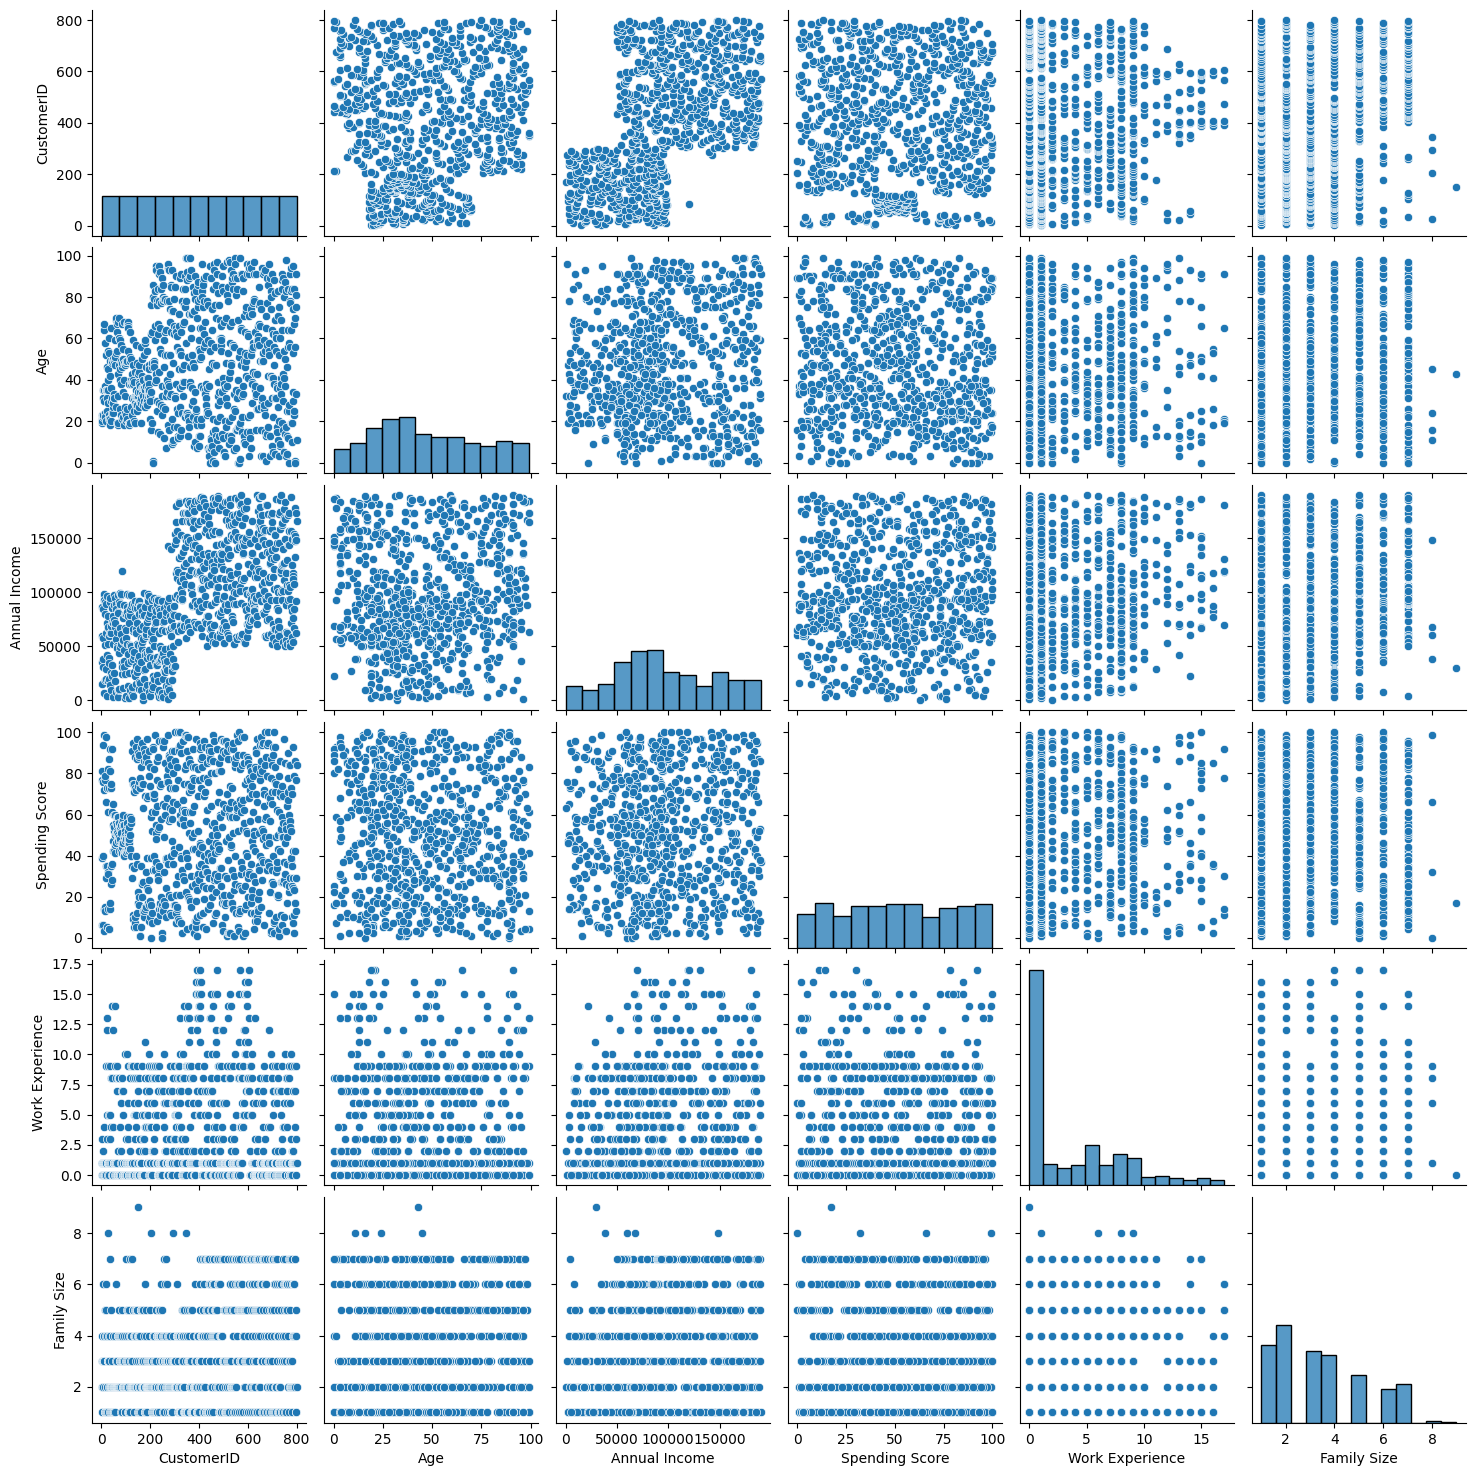

In [5]:
# 1. Detailed EDA
print("Dataset Information:")
print(data.info())
print("Mean",data.mean())
print("Median", data.median())
print("Mode",data.mode())
print("\nMissing Values:\n", data.isnull().sum())
print("\nBasic Statistics:\n", data.describe())
print("\nUnique Values in Each Column:\n", data.nunique())
sns.pairplot(data.select_dtypes(include=['number']))
plt.show()

# Missing values
data['Profession'].fillna(data['Profession'].mode()[0], inplace=True)

# Categorical variables
data_encoded = pd.get_dummies(data, columns=['Gender', 'Profession'], drop_first=True)

# Define features (X) and target (y)
X = data_encoded.drop(columns=['CustomerID', 'Spending Score'])
y = data_encoded['Spending Score']

# Bin target variable for classification
y = pd.cut(y, bins=3, labels=[0, 1, 2])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# 2. Train Gaussian
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

# Accuracy for Gaussian
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print("GaussianNB Accuracy:", accuracy_gnb)

GaussianNB Accuracy: 0.3541666666666667


In [7]:
# 3. Train Multinomial
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)

# Accuracy for Multinomial
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
print("MultinomialNB Accuracy:", accuracy_mnb)

MultinomialNB Accuracy: 0.35



GaussianNB Confusion Matrix:
 [[ 47 126  79]
 [ 41 162  80]
 [ 32 131 102]]


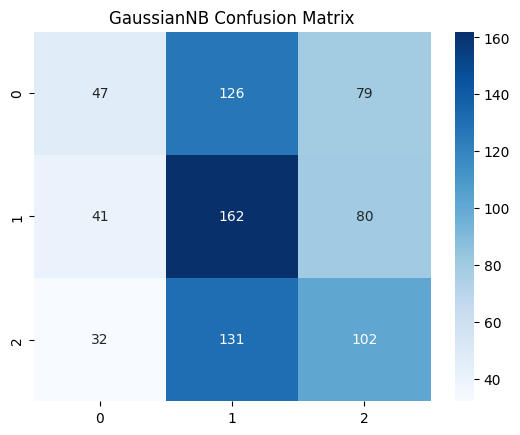


MultinomialNB Confusion Matrix:
 [[ 13 128 111]
 [ 20 149 114]
 [ 11 119 135]]


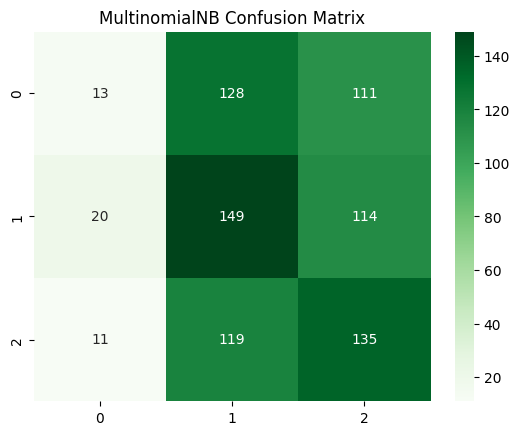

In [8]:
# 4. Confusion matrix with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Confusion Matrix for GaussianNB
y_cv_pred_gnb = cross_val_predict(gnb, X, y, cv=cv)
cm_gnb = confusion_matrix(y, y_cv_pred_gnb)
print("\nGaussianNB Confusion Matrix:\n", cm_gnb)
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues')
plt.title("GaussianNB Confusion Matrix")
plt.show()

# Confusion Matrix for MultinomialNB
y_cv_pred_mnb = cross_val_predict(mnb, X, y, cv=cv)
cm_mnb = confusion_matrix(y, y_cv_pred_mnb)
print("\nMultinomialNB Confusion Matrix:\n", cm_mnb)
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Greens')
plt.title("MultinomialNB Confusion Matrix")
plt.show()

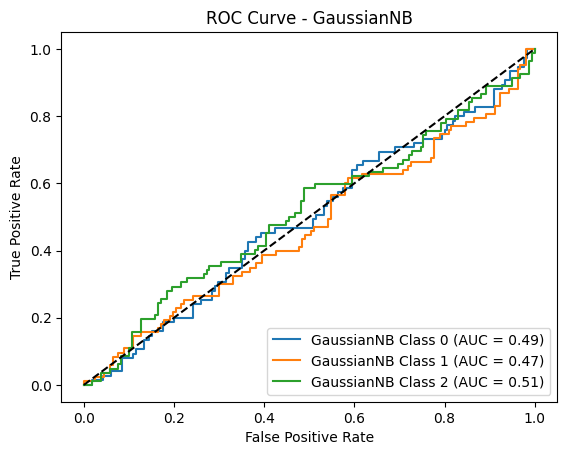

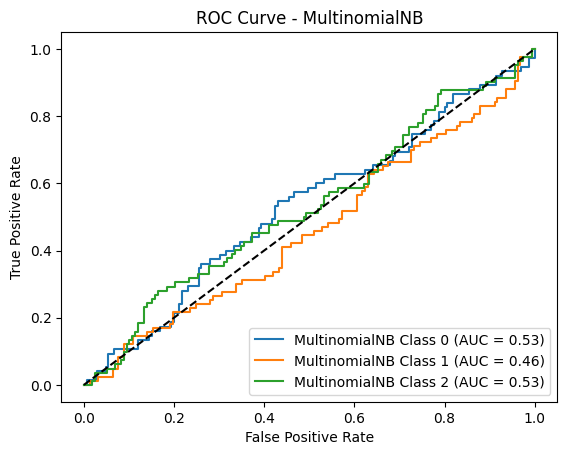

In [ ]:
# One-hot encode y_test for multi-class ROC
y_bin_test = label_binarize(y_test, classes=[0, 1, 2])  # Match the binning labels (0, 1, 2)

# ROC for GaussianNB
y_score_gnb = gnb.predict_proba(X_test)  # Probabilities from GaussianNB
fpr_gnb = {}
tpr_gnb = {}
roc_auc_gnb = {}

# Calculate ROC and AUC for each class
for i in range(y_bin_test.shape[1]):
    fpr_gnb[i], tpr_gnb[i], _ = roc_curve(y_bin_test[:, i], y_score_gnb[:, i])
    roc_auc_gnb[i] = auc(fpr_gnb[i], tpr_gnb[i])

# Plot ROC Curve for GaussianNB
plt.figure()
for i in range(y_bin_test.shape[1]):
    plt.plot(fpr_gnb[i], tpr_gnb[i], label=f'GaussianNB Class {i} (AUC = {roc_auc_gnb[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - GaussianNB")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

# ROC for MultinomialNB
y_score_mnb = mnb.predict_proba(X_test)  # Probabilities from MultinomialNB
fpr_mnb = {}
tpr_mnb = {}
roc_auc_mnb = {}

# Calculate ROC and AUC for each class
for i in range(y_bin_test.shape[1]):
    fpr_mnb[i], tpr_mnb[i], _ = roc_curve(y_bin_test[:, i], y_score_mnb[:, i])
    roc_auc_mnb[i] = auc(fpr_mnb[i], tpr_mnb[i])

# Plot ROC Curve for MultinomialNB
plt.figure()
for i in range(y_bin_test.shape[1]):
    plt.plot(fpr_mnb[i], tpr_mnb[i], label=f'MultinomialNB Class {i} (AUC = {roc_auc_mnb[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - MultinomialNB")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


In [8]:
# 7. Interpretation
print("\nInterpretation:")
print("GaussianNB achieved an accuracy of {:.2f}, while MultinomialNB achieved {:.2f}.".format(accuracy_gnb, accuracy_mnb))
print("Confusion matrices and ROC curves provide insights into the performance of both models. GaussianNB performed better at differentiating between target classes based on probabilities, as indicated by its AUC score.")


Interpretation:
GaussianNB achieved an accuracy of 0.35, while MultinomialNB achieved 0.35.
Confusion matrices and ROC curves provide insights into the performance of both models. GaussianNB performed better at differentiating between target classes based on probabilities, as indicated by its AUC score.
